# Repaso teorico sobre redes de hopfield

Las neuronas de la red de hopfield necesita tantas neuronas como elementos a memorizar si quiero aprender una imagen de 20x20 necesitare 400 neuronas

los pesos de las neuronas se pueden representar en una matriz de pesos, la diagonal de la matriz son ceros, la neurona no esta conectada consigo misma

Anotar aca resulta comodo

Si inicializo la red en el patrón que se le enseño se espera que se quede allí

VERIFICAR QUE LA RED APRENDIO

Las cosas que le muestro a la red lo hago al azar y balanceado, asi la rede ocnverge a un rede bajo y funciona de mejor manera, no se debe actualizar la red siempre de la misma forma

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt 
from PIL import Image
import random

In [2]:
class red_hopfield:

    def __init__(self, cantidad_neuronas = 10):
        self.cantidad_neuronas = cantidad_neuronas
        self.pesos = np.zeros([self.cantidad_neuronas, self.cantidad_neuronas])

    def _mi_sgn(self, a):
        signo = 1
        if a < 0:
            signo = -1
        
        return signo
    
    def entrenar_red(self, patrones, tasa_aprendizaje=0.5):
        for patron in patrones:
            patron = patron.reshape(-1, 1)
            self.pesos += tasa_aprendizaje*patron @ patron.T

        np.fill_diagonal(self.pesos, 0)
                    

    def predecir(self, entrada, steps=3000):
        estado = np.copy(entrada)
        indices = np.linspace(0, self.cantidad_neuronas-1, self.cantidad_neuronas)

        for _ in range(steps):
            indices = np.random.permutation(indices)
            for indice in indices:
                hi = self.pesos[int(indice)] @ estado
                estado[int(indice)] = self._mi_sgn(hi) 

        return estado

    def predecir_sync(self, entrada, steps=10):
        estado = np.copy(entrada)

        for _ in range(steps):
            hi = self.pesos @ estado
            for i in range(self.cantidad_neuronas):
                estado[i] = self._mi_sgn(hi[i])

        return estado

    def imagen_a_patron(self, ruta):

        imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)

        dimension_origianl = imagen.shape
        
        # Binarizar la imagen: valores mayores a 128 serán 1, de lo contrario -1
        _, binarizada_img = cv2.threshold(imagen, 128, 255, cv2.THRESH_BINARY)
        
        binarizacion = np.where(binarizada_img == 255, 1, -1)

        patron = binarizacion.flatten()
        # Si la imagen es más pequeña que el tamaño máximo, rellenamos con -1 (o 0 si prefieres)
        patron_relleno = np.pad(patron, (0, self.cantidad_neuronas - patron.size), 'constant', constant_values=-1)

        # Convertir la matriz 2D en un vector 1D
        return patron_relleno, dimension_origianl, imagen

    @staticmethod
    def patron_a_imagen(patron, dimension_original):
        # Recortar el patrón a la forma original
        patron_redimensionado = patron[:dimension_original[0] * dimension_original[1]].reshape(dimension_original)
        
        # Convertimos los valores +1, -1 a escala de grises 0-255 para que pueda guardarse como imagen
        img_array = np.where(patron_redimensionado == 1, 255, 0).astype(np.uint8)
        
        return img_array
    
    def capacidad(self, pmax):
        return pmax/self.cantidad_neuronas

    def contar_errores(self, patron, test):
        errores = np.count_nonzero(patron - test)
        return errores

    def calc_error(self, m, errores_totales):
        return errores_totales/(self.cantidad_neuronas * m)

    def crear_patrones_aleatorios(self, n, p=0.5):
        patrones = []
        for i in range(n):
            patron =  np.random.binomial(1, 0.5, self.cantidad_neuronas)
            patron = patron*2 - 1
            patrones.append(patron)
        return patrones
def borrar_porcentaje_imagen(input_image_path, output_image_path, porcentaje, color_borrar=0):
    # Abrir la imagen
    img = Image.open(input_image_path)
    pixels = img.load()

    # Obtener dimensiones de la imagen
    width, height = img.size
    total_pixeles = width * height

    # Calcular cuántos píxeles debemos borrar
    pixeles_a_borrar = int(total_pixeles * (porcentaje / 100))

    # Crear una lista de todas las coordenadas de la imagen
    coordenadas = [(x, y) for x in range(width) for y in range(height)]

    # Seleccionar al azar las coordenadas a borrar
    coordenadas_borrar = random.sample(coordenadas, pixeles_a_borrar)


    # Borrar los píxeles (cambiarlos al color especificado)
    for coord in coordenadas_borrar:
        pixels[coord] = color_borrar

    # Guardar la imagen modificada
    img.save(output_image_path)


def sumar_imagenes_bn(output_image_path, *image_paths):
    # Verificar que hay al menos una imagen
    if len(image_paths) < 2:
        raise ValueError("Debes proporcionar al menos dos imágenes para sumar")

    # Abrir la primera imagen en modo 'L' (blanco y negro)
    img_suma = Image.open(image_paths[0]).convert('L')
    pixels_suma = img_suma.load()

    # Verificar que las otras imágenes tengan el mismo tamaño
    for image_path in image_paths[1:]:
        img = Image.open(image_path).convert('L')
        if img.size != img_suma.size:
            raise ValueError("Todas las imágenes deben tener el mismo tamaño")

        # Cargar los píxeles de la imagen actual
        pixels_img = img.load()

        # Sumar los píxeles de la imagen actual a la imagen suma
        for x in range(img.width):
            for y in range(img.height):
                # Obtener los valores de gris de la imagen actual y la imagen suma
                suma_actual = pixels_suma[x, y]
                val_img = pixels_img[x, y]

                # Sumar los valores de los píxeles y limitar a 255 (para evitar desbordamiento)
                suma = min(suma_actual + val_img, 255)

                # Actualizar el valor en la imagen suma
                pixels_suma[x, y] = suma

    # Guardar la imagen resultante
    img_suma.save(output_image_path)




borrar_porcentaje_imagen("imagenes_50_50\\panda.bmp", "panda_25.bmp", 25)
borrar_porcentaje_imagen("imagenes_50_50\\panda.bmp", "panda_50.bmp", 50)
borrar_porcentaje_imagen("imagenes_50_50\\panda.bmp", "panda_75.bmp", 75)

borrar_porcentaje_imagen("imagenes_45_60\\paloma.bmp", "paloma_25.bmp", 25)
borrar_porcentaje_imagen("imagenes_45_60\\paloma.bmp", "paloma_50.bmp", 50)
borrar_porcentaje_imagen("imagenes_45_60\\paloma.bmp", "paloma_75.bmp", 75)

sumar_imagenes_bn('imagen_suma.bmp', 'imagenes_50_50\\perro.bmp', 'imagenes_50_50\\v.bmp', 'imagenes_50_50\\panda.bmp')

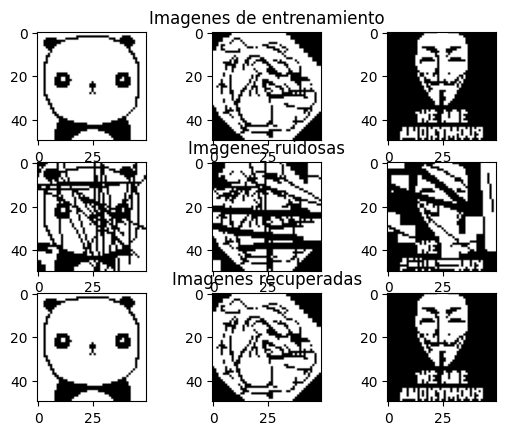

In [3]:
red = red_hopfield((50*50))

carpeta = "imagenes_50_50"
carpeta_prueba = "50_50_ruidosas"

archivos = os.listdir(carpeta)
pruebas = os.listdir(carpeta_prueba)

patrones = []
dimensiones = []
patrones_recuperados = []

patrones_ruidosos = []
dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []

for imagen in archivos:
    if ".bmp" in imagen:
        patron, dimension, imagen_entrenamiento = red.imagen_a_patron(f"imagenes_50_50\\{imagen}")
        patrones.append(patron)
        dimensiones.append(dimension)
        imagenes_entrenamiento.append(imagen_entrenamiento)
        
red.entrenar_red(patrones=patrones, tasa_aprendizaje=0.5)

for prueba in pruebas:
    if "bmp" in prueba:
        patron, dimension, imagen_ruidosa = red.imagen_a_patron(f"{carpeta_prueba}\\{prueba}")
        patrones_ruidosos.append(patron)
        dimensiones_ruidosas.append(dimension)
        imagenes_ruidosas.append(imagen_ruidosa)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red.predecir(patron, 20)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1

fig, axs = plt.subplots(3, 3)

axs[0, 1].set_title("Imagenes de entrenamiento")
axs[1, 1].set_title("Imagenes ruidosas")
axs[2, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_entrenamiento[0], cmap='gray')
axs[0, 1].imshow(imagenes_entrenamiento[1], cmap='gray')
axs[0, 2].imshow(imagenes_entrenamiento[2], cmap='gray')

axs[1, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[1, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[1, 2].imshow(imagenes_ruidosas[2], cmap='gray')

axs[2, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[2, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[2, 2].imshow(imagenes_recuperadas[2], cmap='gray')



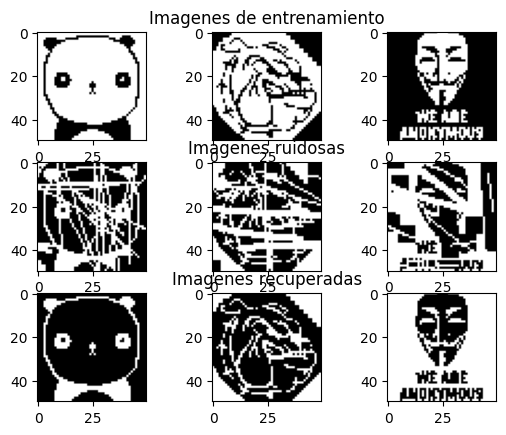

In [4]:
nuevos_recuperados = []
ruido_inverso = []
iter = 0
for patron in patrones_ruidosos:
    patron = -1*patron
    nuevo = red.predecir(patron, 20)
    ruido = red_hopfield.patron_a_imagen(patron, dimensiones_ruidosas[iter])
    nueva_imagen = red_hopfield.patron_a_imagen(nuevo, dimensiones_ruidosas[iter])
    ruido_inverso.append(ruido)
    nuevos_recuperados.append(nueva_imagen)
    iter += 1


fig, axs = plt.subplots(3, 3)

axs[0, 1].set_title("Imagenes de entrenamiento")
axs[1, 1].set_title("Imagenes ruidosas")
axs[2, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_entrenamiento[0], cmap='gray')
axs[0, 1].imshow(imagenes_entrenamiento[1], cmap='gray')
axs[0, 2].imshow(imagenes_entrenamiento[2], cmap='gray')

axs[1, 0].imshow(ruido_inverso[0], cmap='gray')
axs[1, 1].imshow(ruido_inverso[1], cmap='gray')
axs[1, 2].imshow(ruido_inverso[2], cmap='gray')

axs[2, 0].imshow(nuevos_recuperados[0], cmap='gray')
axs[2, 1].imshow(nuevos_recuperados[1], cmap='gray')
axs[2, 2].imshow(nuevos_recuperados[2], cmap='gray')



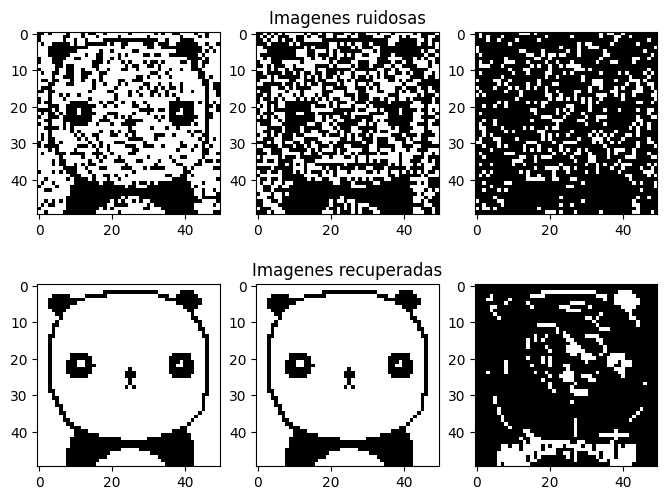

In [5]:
carpeta_prueba = "panda_ruidoso_porcentual"

pruebas = os.listdir(carpeta_prueba)

patrones = []
dimensiones = []
patrones_recuperados = []

patrones_ruidosos = []
dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []
        
for prueba in pruebas:
    if "bmp" in prueba:
        patron, dimension, imagen_ruidosa = red.imagen_a_patron(f"{carpeta_prueba}\\{prueba}")
        patrones_ruidosos.append(patron)
        dimensiones_ruidosas.append(dimension)
        imagenes_ruidosas.append(imagen_ruidosa)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red.predecir(patron, 20)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1

fig, axs = plt.subplots(2, 3, figsize=(8,6))

axs[0, 1].set_title("Imagenes ruidosas")
axs[1, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[0, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[0, 2].imshow(imagenes_ruidosas[2], cmap='gray')

axs[1, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[1, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[1, 2].imshow(imagenes_recuperadas[2], cmap='gray')


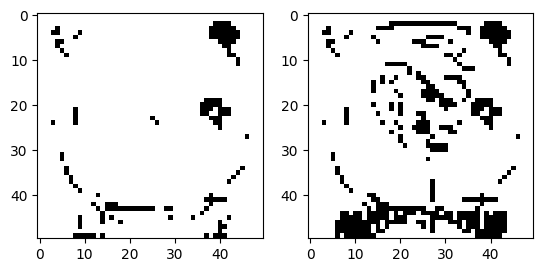

In [6]:
patron, dimension, imagen_= red.imagen_a_patron(f"imagen_suma.bmp")

patron_recuperado = red.predecir(patron, 70)
imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimension)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(imagen_, cmap='gray')
axs[1].imshow(imagen, cmap='gray')

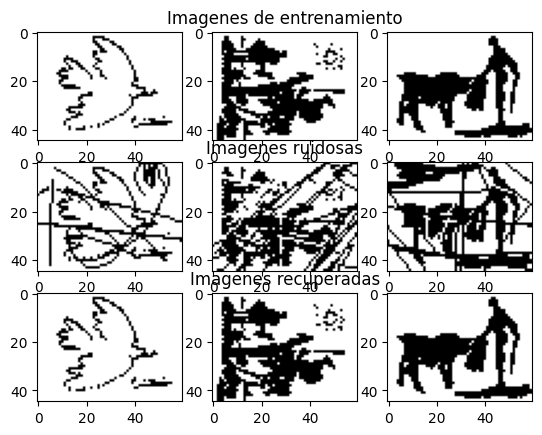

In [7]:
red2 = red_hopfield((45*60))

carpeta = "imagenes_45_60"
carpeta_prueba = "45_60_ruidosas"

archivos = os.listdir(carpeta)
pruebas = os.listdir(carpeta_prueba)

patrones = []
dimensiones = []
patrones_recuperados = []

patrones_ruidosos = []
dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []

for imagen in archivos:
    if ".bmp" in imagen:
        patron, dimension, imagen_entrenamiento = red2.imagen_a_patron(f"{carpeta}\\{imagen}")
        patrones.append(patron)
        dimensiones.append(dimension)
        imagenes_entrenamiento.append(imagen_entrenamiento)
        
red2.entrenar_red(patrones=patrones, tasa_aprendizaje=0.5)

for prueba in pruebas:
    if "bmp" in prueba:
        patron, dimension, imagen_ruidosa = red2.imagen_a_patron(f"{carpeta_prueba}\\{prueba}")
        patrones_ruidosos.append(patron)
        dimensiones_ruidosas.append(dimension)
        imagenes_ruidosas.append(imagen_ruidosa)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red2.predecir(patron, 20)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1

fig, axs = plt.subplots(3, 3)

axs[0, 1].set_title("Imagenes de entrenamiento")
axs[1, 1].set_title("Imagenes ruidosas")
axs[2, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_entrenamiento[0], cmap='gray')
axs[0, 1].imshow(imagenes_entrenamiento[1], cmap='gray')
axs[0, 2].imshow(imagenes_entrenamiento[2], cmap='gray')

axs[1, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[1, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[1, 2].imshow(imagenes_ruidosas[2], cmap='gray')

axs[2, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[2, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[2, 2].imshow(imagenes_recuperadas[2], cmap='gray')



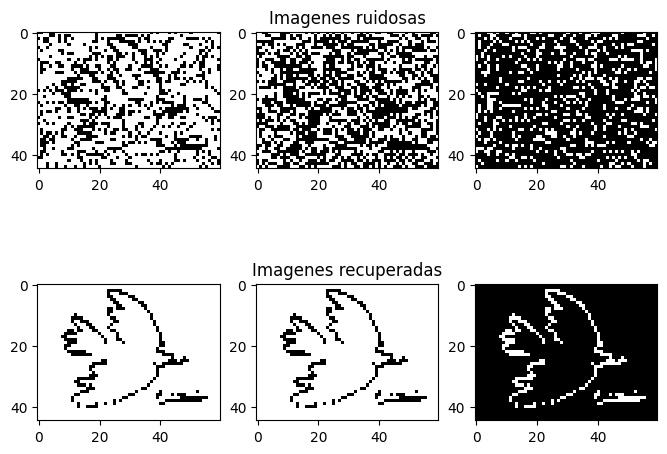

In [8]:
carpeta_prueba = "paloma_ruido_porcentual"

pruebas = os.listdir(carpeta_prueba)

patrones = []
dimensiones = []
patrones_recuperados = []

patrones_ruidosos = []
dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []
        
for prueba in pruebas:
    if "bmp" in prueba:
        patron, dimension, imagen_ruidosa = red2.imagen_a_patron(f"{carpeta_prueba}\\{prueba}")
        patrones_ruidosos.append(patron)
        dimensiones_ruidosas.append(dimension)
        imagenes_ruidosas.append(imagen_ruidosa)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red2.predecir(patron, 20)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1

fig, axs = plt.subplots(2, 3, figsize=(8,6))

axs[0, 1].set_title("Imagenes ruidosas")
axs[1, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[0, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[0, 2].imshow(imagenes_ruidosas[2], cmap='gray')

axs[1, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[1, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[1, 2].imshow(imagenes_recuperadas[2], cmap='gray')



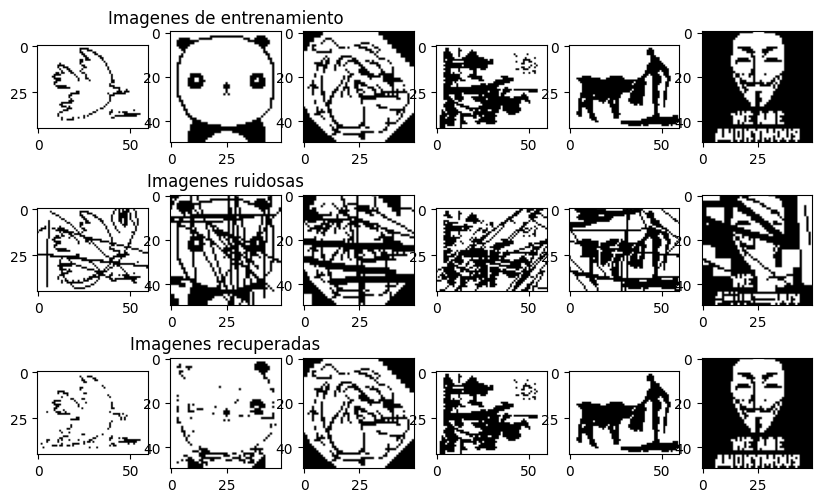

In [9]:
red3 = red_hopfield(45*60)

carpeta_6 = 'imagenes'
carpeta_de_test = 'imagenes_ruidosas'

archivos = os.listdir(carpeta_6)
pruebas = os.listdir(carpeta_de_test)

patrones = []
patrones_ruidosos = []
patrones_recuperados = []

dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []

for imagen in archivos:
    patron, dimension, imagen = red3.imagen_a_patron(f"{carpeta_6}\\{imagen}")
    patrones.append(patron)
    imagenes_entrenamiento.append(imagen)

red3.entrenar_red(patrones)

for imagen in pruebas:
    patron, dimension, imagen = red3.imagen_a_patron(f"{carpeta_de_test}\\{imagen}")
    patrones_ruidosos.append(patron)
    dimensiones_ruidosas.append(dimension)
    imagenes_ruidosas.append(imagen)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red3.predecir(patron, 30)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1

fig, axs = plt.subplots(3, 6, figsize=(10,6))

axs[0, 1].set_title("Imagenes de entrenamiento")
axs[1, 1].set_title("Imagenes ruidosas")
axs[2, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_entrenamiento[0], cmap='gray')
axs[0, 1].imshow(imagenes_entrenamiento[1], cmap='gray')
axs[0, 2].imshow(imagenes_entrenamiento[2], cmap='gray')
axs[0, 3].imshow(imagenes_entrenamiento[3], cmap='gray')
axs[0, 4].imshow(imagenes_entrenamiento[4], cmap='gray')
axs[0, 5].imshow(imagenes_entrenamiento[5], cmap='gray')

axs[1, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[1, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[1, 2].imshow(imagenes_ruidosas[2], cmap='gray')
axs[1, 3].imshow(imagenes_ruidosas[3], cmap='gray')
axs[1, 4].imshow(imagenes_ruidosas[4], cmap='gray')
axs[1, 5].imshow(imagenes_ruidosas[5], cmap='gray')

axs[2, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[2, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[2, 2].imshow(imagenes_recuperadas[2], cmap='gray')
axs[2, 3].imshow(imagenes_recuperadas[3], cmap='gray')
axs[2, 4].imshow(imagenes_recuperadas[4], cmap='gray')
axs[2, 5].imshow(imagenes_recuperadas[5], cmap='gray')



In [10]:
lista = [[0, 1 , 2]]
np.squeeze(lista)

array([0, 1, 2])

In [11]:
p_error = [0.001, 0.0036, 0.01, 0.05, 0.1]
pmax_N = [0.105, 0.138, 0.185, 0.37, 0.61]

N = 400
M = 1

capacidad = 0
capacidades = []

for cota in p_error:
    red_ej2 = red_hopfield(N)
    patrones = []
    iter = 0
    error = 0
    while error < cota and iter <= 50:
        errores = 0
        patron = red_ej2.crear_patrones_aleatorios(1)
        patrones.append(patron)
        red_ej2.entrenar_red(patron)
        for patron_aprendido in patrones:
            patron_test = red_ej2.predecir_sync(np.squeeze(patron_aprendido))
            errores_por_patron = red_ej2.contar_errores(patron_test, patron_aprendido)
            errores += errores_por_patron
        error = red_ej2.calc_error(len(patrones), errores)
        iter += 1

    capacidad = red_ej2.capacidad(len(patrones))
    capacidades.append(capacidad)
capacidades

[0.105, 0.125, 0.1275, 0.1275, 0.1275]

In [14]:
p_error = [0.001, 0.0036, 0.01, 0.05, 0.1]
pmax_N = [0.105, 0.138, 0.185, 0.37, 0.61]

N = 500
M = 1

capacidad = 0
capacidades = []
red_ej2 = red_hopfield(N)
patrones = []
pmaxs = []
error = 0
errores = 0
for cota in p_error:

    while error < cota :
      
        patron = red_ej2.crear_patrones_aleatorios(1)
        patrones.append(patron)
        red_ej2.entrenar_red(patron)
        for patron_aprendido in patrones:
            patron_test = red_ej2.predecir_sync(np.squeeze(patron_aprendido), 1)
            errores_por_patron = red_ej2.contar_errores(patron_test, patron_aprendido)
            errores += errores_por_patron
        error = red_ej2.calc_error(len(patrones), errores)
        errores = 0

    capacidad = red_ej2.capacidad(len(patrones))
    pmaxs.append(len(patrones))
    capacidades.append(capacidad)

capacidades, pmaxs

([0.112, 0.142, 0.188, 0.372, 0.612], [56, 71, 94, 186, 306])

# Entrega del tp1 02/10!!!

tolerancia de error, definimos un maximo error tolerable, y con ello definimos la capacidad

\begin{equation*}
    \text{Capacidad} = \dfrac{\text{P}_{MAX}}{N}
\end{equation*}

N cantidad de neuronas 

M cantidad de patrones

\begin{equation*}
    \text{E} = \dfrac{\#\text{ errores totales}}{N.M}
\end{equation*}
- construyo $\bar{P}$, $\bar{P}(i)$ $\epsilon$ {1, - 1}, probb($\bar{P}$(i) = 1) = 1/2
- enseño $\bar{P}$
- Act sinc
- computo E
- Pmax+1 $\to$ Pmax

In [16]:
3000*0.105

315.0

In [29]:
import numpy as np
from scipy.stats import multivariate_normal

def generate_correlated_bernoulli(n, p, rho):
    # n: Número de muestras
    # p: Probabilidad de éxito de la variable Bernoulli
    # rho: Correlación deseada entre las variables

    # Matriz de covarianza para la normal multivariada
    cov_matrix = np.array([[1, rho], [rho, 1]])

    # Generar variables latentes normales correlacionadas
    latent_vars = multivariate_normal(mean=[0, 0], cov=cov_matrix).rvs(size=n)

    # Aplicar el umbral para obtener las variables Bernoulli
    bernoulli_samples = (latent_vars > np.array([np.percentile(latent_vars[:, 0], 100*(1-p)),
                                                 np.percentile(latent_vars[:, 1], 100*(1-p))])).astype(int)

    return bernoulli_samples

# Ejemplo: Generar 10 muestras correlacionadas con p = 0.5 y correlación 0.8
samples = generate_correlated_bernoulli(10, 0.5, 0.8)
print(samples)



[[1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]]
nan
